In [49]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
#data = pd.read_csv('ES7-26-22_to_9-18-24.csv')
data = pd.read_csv('NEED_TO_APPEND.csv')

#testing random feature drops
data = data.drop(columns='FT')
#data = data.drop(columns='FullK')
#data = data.drop(columns='diffKD')
#data = data.drop(columns='OB')
#data = data.drop(columns='OS')
#data = data.drop(columns='vol')
#data = data.drop(columns='s15')
#data = data.drop(columns='s30')
#data = data.drop(columns='s60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='Inertias')
#data = data.drop(columns='percBB')
#data = data.drop(columns='spreadRSI')
#data = data.drop(columns='ADX')
#data = data.drop(columns='RSI')
#data = data.drop(columns='Wpercent')
#data = data.drop(columns='acc')

#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='bull15')
data = data.drop(columns='bear15')

data = data.drop(columns='bull30')
data = data.drop(columns='bear30')

data = data.drop(columns='bull60')
data = data.drop(columns='bear60')

#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

NinRows = data.drop(data[data['bull15'] == 'in'].index)

inRows = data.drop(data[data['bull15'] != 'in'].index)

inRowsMatch = inRows.loc[0:2740]

print('ins -\t',inRows.index.size,'\ninsMatch -\t',\
      inRowsMatch.index.size,'\nnon-ins -\t',NinRows.index.size)

optData = pd.concat([NinRows, inRowsMatch],axis=0)

percIn = data.size/(inRows.size*2)
percNin = data.size/(NinRows.size*2)
weight_for_0 = percIn
weight_for_1 = percNin
cw = {0: weight_for_1, 1: weight_for_0}

print("PERCENT & WEIGHTS:\nINS\t-\t",percIn*100," %\nNon-INS\t-\t",percNin*100," %",sep='')

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))



#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values



#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

def custom_loss(y_true, y_pred):
        
        # Standard binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Define penalties for false negatives (y_true = 1, y_pred = 0)
        false_negatives_penalty = 0.0  # Penalty for false negatives
        false_positives_penalty = 5.0  # Penalty for false positives
        
        # Define reward for true positives (y_true = 1, y_pred = 1)
        true_positives_reward = -2.0  # Negative value to reduce the loss when TP happens

        # Calculate false negatives and false positives
        false_negatives = y_true * (1 - y_pred)
        false_positives = (1 - y_true) * y_pred
        
        # Calculate true positives
        true_positives = y_true * y_pred
        
        # Apply penalties and rewards
        penalties = false_negatives_penalty * false_negatives + false_positives_penalty * false_positives
        rewards = true_positives_reward * true_positives
        
        # Return combined loss (penalize FNs and FPs, reward TPs)
        return bce + penalties + rewards

loaded_model = tf.keras.models.load_model('trainedBoth.keras',custom_objects={"custom_loss":custom_loss})
met = ['Accuracy','AUC','Precision','Recall','TrueNegatives','TruePositives','FalsePositives','FalseNegatives']
loaded_model.compile(optimizer='adam', loss=custom_loss, metrics=met)


TESTED FEATURES: 
Index(['FullK', 'diffKD', 'OB', 'OS', 'vol', 's15', 's30', 's60', 'ToD',
       'Inertias', 'percBB', 'spreadRSI', 'ADX', 'RSI', 'Wpercent', 'acc'],
      dtype='object')
TESTING FOR: 
bull15
OCCURANCES IN RAW DATA FOR bull15: 
{'in': 23257, 'up': 2443}
ins -	 23257 
insMatch -	 2443 
non-ins -	 2443
PERCENT & WEIGHTS:
INS	-	55.25218213871093 %
Non-INS	-	525.992632009824 %
OCCURANCES IN RAW DATA FOR bull15: 
{'in': 2443, 'up': 2443}


804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


<Axes: >

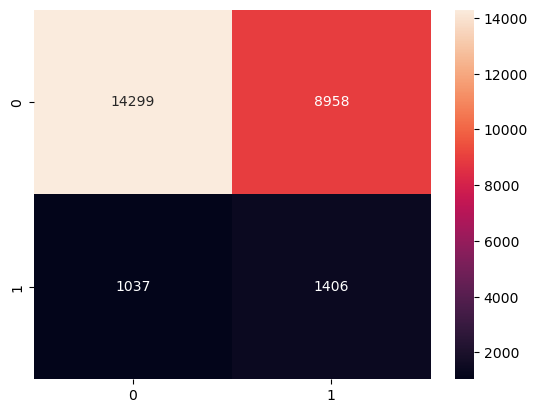

In [54]:
#predicting the test set results
threshold = 0.2
y_pred = loaded_model.predict(X)
y_pred = (y_pred > threshold)

#making a confusion matrix
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

#PRINTS OUT ALL GUESSES
#[print(x) for x in y_pred]